In [1]:
import keras

from keras.initializers import Initializer
from sklearn.cluster import KMeans

from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam,SGD

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# kmeans layer
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=10):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        print(shape,self.X.shape)
        assert shape[1] == self.X.shape[1]        
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [3]:
## RBF layer 
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        XC = K.transpose(K.transpose(x)-C)     
        D = K.expand_dims(K.sqrt(K.mean(XC**2,axis=0)),0) 
        H = XC/D
        return K.exp(-self.betas * K.sum(XC**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## 生成数据

In [4]:
def maxminnorm(array):
    maxcols=array.max(axis=0)
    mincols=array.min(axis=0)
    data_shape = array.shape
    data_rows = data_shape[0]
    data_cols = data_shape[1]
    t=np.empty((data_rows,data_cols))
    for i in range(data_cols):
        t[:,i]=(array[:,i]-mincols[i])/(maxcols[i]-mincols[i])
    return t

In [5]:
## create dataset
# reference https://zhuanlan.zhihu.com/p/36982945
def test_data1(sample_number = 1000):
    #随机从高斯分布中生成两个数据集
    mean0=[2,7]
    cov=np.mat([[1,0],[0,2]])
    data1=np.random.multivariate_normal(mean0,cov,sample_number)

    mean1=[8,3]
    cov=np.mat([[1,0],[0,2]])
    data2=np.random.multivariate_normal(mean1,cov,sample_number)
    
    y1 = np.zeros((sample_number,1))#第一类，标签为0
    y2 = np.ones((sample_number,1))#第二类类，标签为1
    
    train_data = np.vstack((data1,data2))
    train_label = np.vstack((y1,y2))
    
    shuffle_idx = np.arange(sample_number*2)
    np.random.shuffle(shuffle_idx)
    
    train_data = train_data[shuffle_idx]
    train_label = train_label[shuffle_idx]
    return train_data,train_label

In [6]:
## create dataset
# reference https://zhuanlan.zhihu.com/p/36982945
def test_data2(sample_number = 1000):
    #随机均匀分布中生成数据
    all_data = np.random.rand(sample_number*2,2)
    data1 = all_data[all_data[...,0]>all_data[...,1]]
    data2 = all_data[all_data[...,0]<=all_data[...,1]]
    y1 = np.zeros((data1.shape[0],1))#第一类，标签为0
    y2 = np.ones((data2.shape[0],1))#第二类类，标签为1
    
    train_data = np.vstack((data1,data2))
    train_label = np.vstack((y1,y2))
    
    shuffle_idx = np.arange(sample_number*2)
    np.random.shuffle(shuffle_idx)
    
    train_data = train_data[shuffle_idx]
    train_label = train_label[shuffle_idx]
    return train_data,train_label

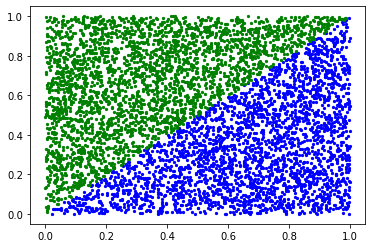

In [7]:
samples_num = 3000
train_data,train_label = test_data2(samples_num)
plt.scatter(train_data[np.argwhere(train_label==0),0],train_data[np.argwhere(train_label==0),1],s=5,c='b')
plt.scatter(train_data[np.argwhere(train_label==1),0],train_data[np.argwhere(train_label==1),1],s=5,c='g')

## 生成模型

In [8]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersKMeans(train_data),
                    betas=2.0,
                    input_shape=(2,))
model.add(rbflayer)
model.add(Dense(1,activation='sigmoid'))

(10, 2) (6000, 2)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
model.compile(loss=binary_crossentropy,optimizer=Adam(),metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
model.fit(train_data,train_label,epochs=500,batch_size=samples_num)


Epoch 1/500
6000/6000 [==============================] - 0s 55us/step - loss: 0.7675 - accuracy: 0.4773
Epoch 2/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7634 - accuracy: 0.4807
Epoch 3/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7593 - accuracy: 0.4838
Epoch 4/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7552 - accuracy: 0.4863
Epoch 5/500
6000/6000 [==============================] - 0s 2us/step - loss: 0.7512 - accuracy: 0.4883
Epoch 6/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7473 - accuracy: 0.4925
Epoch 7/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7434 - accuracy: 0.4960
Epoch 8/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7395 - accuracy: 0.4987
Epoch 9/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.7356 - accuracy: 0.5025
Epoch 10/500
6000/6000 [==============================] - 0s 1us/step -

6000/6000 [==============================] - 0s 1us/step - loss: 0.5371 - accuracy: 0.7613
Epoch 78/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5347 - accuracy: 0.7638
Epoch 79/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5325 - accuracy: 0.7658
Epoch 80/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5302 - accuracy: 0.7675
Epoch 81/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5279 - accuracy: 0.7703
Epoch 82/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5256 - accuracy: 0.7725
Epoch 83/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5234 - accuracy: 0.7748
Epoch 84/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5212 - accuracy: 0.7772
Epoch 85/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.5189 - accuracy: 0.7785
Epoch 86/500
6000/6000 [==============================] - 0s 1us/step - loss:

6000/6000 [==============================] - 0s 1us/step - loss: 0.3924 - accuracy: 0.8868
Epoch 156/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3910 - accuracy: 0.8882
Epoch 157/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3896 - accuracy: 0.8905
Epoch 158/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3882 - accuracy: 0.8913
Epoch 159/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3868 - accuracy: 0.8923
Epoch 160/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3854 - accuracy: 0.8937
Epoch 161/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3840 - accuracy: 0.8947
Epoch 162/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3826 - accuracy: 0.8955
Epoch 163/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3813 - accuracy: 0.8967
Epoch 164/500
6000/6000 [==============================] - 0s 1us/ste

6000/6000 [==============================] - 0s 1us/step - loss: 0.3075 - accuracy: 0.9455
Epoch 234/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3067 - accuracy: 0.9460
Epoch 235/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3059 - accuracy: 0.9463
Epoch 236/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3051 - accuracy: 0.9467
Epoch 237/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3043 - accuracy: 0.9475
Epoch 238/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3035 - accuracy: 0.9487
Epoch 239/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3028 - accuracy: 0.9492
Epoch 240/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3020 - accuracy: 0.9500
Epoch 241/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.3012 - accuracy: 0.9503
Epoch 242/500
6000/6000 [==============================] - 0s 1us/ste

6000/6000 [==============================] - 0s 1us/step - loss: 0.2574 - accuracy: 0.9708
Epoch 312/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2569 - accuracy: 0.9708
Epoch 313/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2564 - accuracy: 0.9710
Epoch 314/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2559 - accuracy: 0.9715
Epoch 315/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2554 - accuracy: 0.9718
Epoch 316/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2550 - accuracy: 0.9722
Epoch 317/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2545 - accuracy: 0.9725
Epoch 318/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2540 - accuracy: 0.9733
Epoch 319/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2535 - accuracy: 0.9735
Epoch 320/500
6000/6000 [==============================] - 0s 1us/ste

6000/6000 [==============================] - 0s 1us/step - loss: 0.2261 - accuracy: 0.9853
Epoch 390/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2258 - accuracy: 0.9852
Epoch 391/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2254 - accuracy: 0.9852
Epoch 392/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2251 - accuracy: 0.9852
Epoch 393/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2248 - accuracy: 0.9853
Epoch 394/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2245 - accuracy: 0.9853
Epoch 395/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2242 - accuracy: 0.9855
Epoch 396/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2239 - accuracy: 0.9858
Epoch 397/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2236 - accuracy: 0.9860
Epoch 398/500
6000/6000 [==============================] - 0s 1us/ste

6000/6000 [==============================] - 0s 1us/step - loss: 0.2052 - accuracy: 0.9905
Epoch 468/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2050 - accuracy: 0.9905
Epoch 469/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2047 - accuracy: 0.9905
Epoch 470/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2045 - accuracy: 0.9907
Epoch 471/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2043 - accuracy: 0.9907
Epoch 472/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2041 - accuracy: 0.9907
Epoch 473/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2038 - accuracy: 0.9907
Epoch 474/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2036 - accuracy: 0.9908
Epoch 475/500
6000/6000 [==============================] - 0s 1us/step - loss: 0.2034 - accuracy: 0.9908
Epoch 476/500
6000/6000 [==============================] - 0s 1us/ste

## draw test model

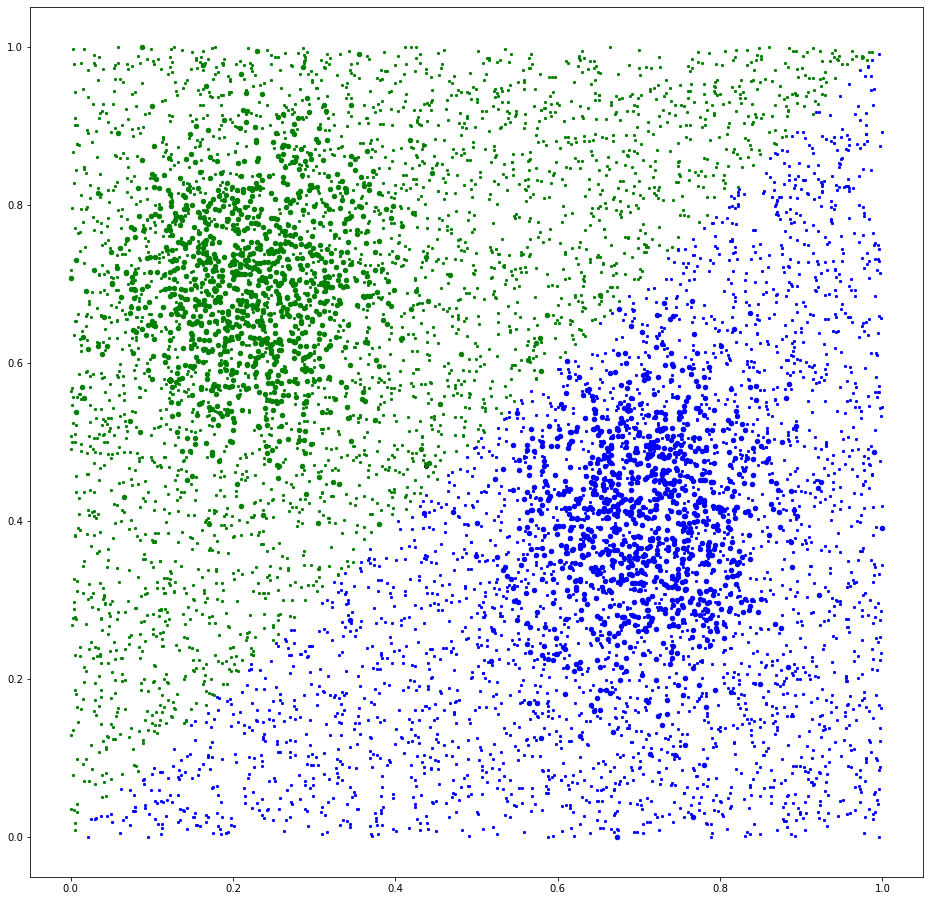

In [11]:
# x1 = np.linspace(-2,12,1000)
# x2 = np.linspace(-2,12,1000)
# test_x = np.vstack((x1,x2)).T

test_x,_ = test_data1()
test_x = maxminnorm(test_x)

test_y = model.predict(test_x)

plt.figure(figsize=(16,16))
# plot the train data
plt.scatter(train_data[np.argwhere(train_label==0),0],train_data[np.argwhere(train_label==0),1],s=5,c='b',marker='x')
plt.scatter(train_data[np.argwhere(train_label==1),0],train_data[np.argwhere(train_label==1),1],s=5,c='g',marker='x')
#plot the test data
plt.scatter(test_x[np.argwhere(test_y<0.5),0],test_x[np.argwhere(test_y<0.5),1],s=20,c='b',marker='o')
plt.scatter(test_x[np.argwhere(test_y>=0.5),0],test_x[np.argwhere(test_y>=0.5),1],s=20,c='g',marker='o')

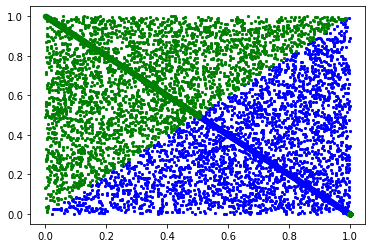

In [12]:
x1 = np.linspace(12,-2,1000)
x2 = np.linspace(-2,12,1000)
test_x = np.vstack((x1,x2)).T

test_x = maxminnorm(test_x)

test_y = model.predict(test_x)
plt.scatter(train_data[np.argwhere(train_label==0),0],train_data[np.argwhere(train_label==0),1],s=5,c='b',marker='x')
plt.scatter(train_data[np.argwhere(train_label==1),0],train_data[np.argwhere(train_label==1),1],s=5,c='g',marker='x')
#plot the test data
plt.scatter(test_x[np.argwhere(test_y<0.5),0],test_x[np.argwhere(test_y<0.5),1],s=20,c='b',marker='o')
plt.scatter(test_x[np.argwhere(test_y>=0.5),0],test_x[np.argwhere(test_y>=0.5),1],s=20,c='g',marker='o')

In [13]:
model.evaluate(x=train_data,y=train_label)

6000/6000 [==============================] - 0s 28us/step


[0.19805974388122558, 0.9919999837875366]